This notebook shows the process of creating the routes using a simple pathfinding algorithm where only the distance is considered.

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import networkx as nx
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import pickle
import csv
import folium
from folium.plugins import MarkerCluster

In [2]:
def get_coordinates():
    while True:
        try:
            # Prompt user for latitude and longitude
            latitude = float(input("Enter the latitude (in decimal degrees): "))
            longitude = float(input("Enter the longitude (in decimal degrees): "))
            
            # Validate if the coordinates are within the bounds of Accra
            if 5.47 <= latitude <= 5.89 and -0.24 <= longitude <= -0.02:
                print(f"Coordinates ({latitude}, {longitude}) are valid for Accra.")
                return latitude, longitude
            else:
                print("Error: The coordinates are not within the valid range for Accra. Please try again.")
        except ValueError:
            print("Error: Please enter valid numeric values for latitude and longitude.")
# Get start and end coordinates from the user
start_lat, start_lon = get_coordinates()
end_lat, end_lon = get_coordinates()


Coordinates (5.608741666152156, -0.075866323410708) are valid for Accra.
Coordinates (5.643041503585579, -0.235185096524191) are valid for Accra.


In [3]:
def create_and_save_graph():
    G = nx.Graph()

    # Add healthcare facilities as nodes and connect them if they are within 7 km of each other
    for idx1, row1 in health_facilities_gdf.iterrows():
        if not no_fly_zones_gdf.contains(row1.geometry).any():
            G.add_node(idx1, pos=(row1['longitude'], row1['latitude']))

            # Check other facilities to create edges within the range
            for idx2, row2 in health_facilities_gdf.iterrows():
                if idx1 != idx2:
                    distance = geodesic((row1['latitude'], row1['longitude']), (row2['latitude'], row2['longitude'])).km
                    
                    if distance <= drone_range_km:
                        line = LineString([row1.geometry, row2.geometry])

                        # Check if the edge intersects any no-fly zones
                        if no_fly_zones_gdf.intersects(line).any():
                            continue  # Skip adding this edge

                        # Adjust the edge weight if it intersects an avoidance zone
                        edge_weight = distance
                        if avoidance_zones_gdf.intersects(line).any():
                            edge_weight *= 10

                        G.add_edge(idx1, idx2, weight=edge_weight)

    # Save the graph to a file
    with open('../output/simple_route.pkl', 'wb') as f:
        pickle.dump(G, f)
    print("Network graph created and saved as 'simple_route.pkl'.")

# Function to load the saved graph
def load_graph():
    with open('../output/simple_route.pkl', 'rb') as f:
        G = pickle.load(f)
    print("Network graph loaded from 'simple_route.pkl'.")
    return G

def add_node_to_graph(G, lat, lon, node_name):
    point = Point(lon, lat)
    if no_fly_zones_gdf.contains(point).any():
        print(f"{node_name} is within a no-fly zone and cannot be added.")
        return None

    # Ensure unique node index
    new_node_idx = max(G.nodes) + 1 if len(G.nodes) > 0 else 0
    G.add_node(new_node_idx, pos=(lon, lat), name=node_name)

    # Ensure the position is stored in the graph's 'pos' attribute
    pos = nx.get_node_attributes(G, 'pos')
    pos[new_node_idx] = (lon, lat)
    nx.set_node_attributes(G, pos, 'pos')

    # Add edges to other nodes within range
    for idx, row in health_facilities_gdf.iterrows():
        distance = geodesic((lat, lon), (row['latitude'], row['longitude'])).km
        if distance <= drone_range_km:
            edge_weight = distance
            line = LineString([point, row.geometry])

            # Check if the edge intersects any no-fly zones
            if no_fly_zones_gdf.intersects(line).any():
                print(f"Edge from {node_name} to {row['name']} intersects a no-fly zone, not adding.")
                continue  # Skip adding this edge
            
            # If it intersects an avoidance zone, increase weight
            if avoidance_zones_gdf.intersects(line).any():
                edge_weight *= 3  # Increase the weight significantly if it intersects an avoidance zone

            G.add_edge(new_node_idx, idx, weight=edge_weight)

    return new_node_idx


# Load the healthcare facilities CSV file
health_facilities_df = pd.read_csv('../data/accra_facilities_filtered.csv')

# Convert the healthcare facilities DataFrame to a GeoDataFrame
health_facilities_gdf = gpd.GeoDataFrame(
    health_facilities_df, 
    geometry=gpd.points_from_xy(health_facilities_df.longitude, health_facilities_df.latitude)
)

# Load the no-fly zones and avoidance areas from GeoJSON files
no_fly_zones_gdf = gpd.read_file('../map/no_fly_zones.geojson')
avoidance_zones_gdf = gpd.read_file('../map/avoidance_zones.geojson')

In [4]:
# Define drone constraints
drone_range_km = 7  # Maximum range of the drone on a single charge
payload_capacity_kg = 2  # Maximum payload capacity of the drone

print(f"Drone constraints: Range = {drone_range_km} km, Payload Capacity = {payload_capacity_kg} kg")

Drone constraints: Range = 7 km, Payload Capacity = 2 kg


Network graph loaded from 'simple_route.pkl'.
Edge from End to Jinlet Pharmacy intersects a no-fly zone, not adding.
Edge from End to Ernest Chemists intersects a no-fly zone, not adding.
Edge from End to Airport Womens Hospital intersects a no-fly zone, not adding.
Shortest path found: [297, 292, 249, 298]


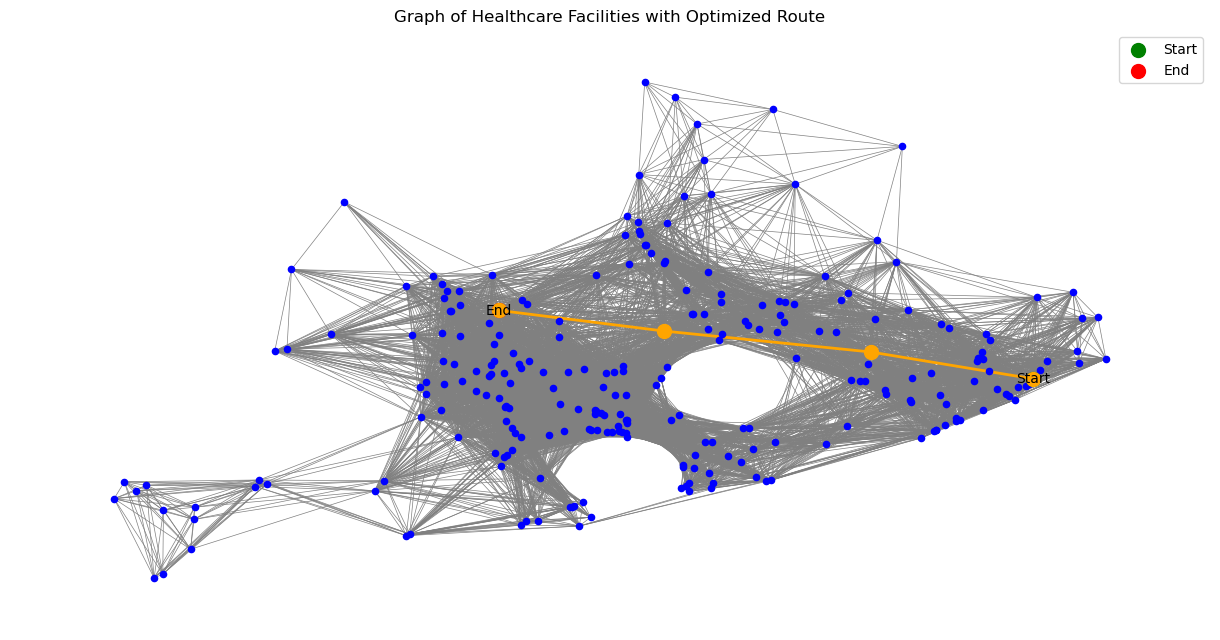

Route data saved to ../output/drone_route.csv


In [5]:
# Check if the graph already exists and load it, otherwise create and save it
try:
    G = load_graph()
except FileNotFoundError:
    create_and_save_graph()
    G = load_graph()

start_node = add_node_to_graph(G, start_lat, start_lon, 'Start')
end_node = add_node_to_graph(G, end_lat, end_lon, 'End')

# If start and end nodes are successfully added, proceed with pathfinding
if start_node is not None and end_node is not None:
    try:
        shortest_path = nx.dijkstra_path(
            G, 
            start_node, 
            end_node, 
            weight='weight'
        )
        print("Shortest path found:", shortest_path)
    except nx.NetworkXNoPath:
        print("No path found between the start and end nodes.")

    # Ensure the pos dictionary is populated correctly
    pos = nx.get_node_attributes(G, 'pos')

    # Check for nodes without positions and remove them from the graph
    missing_pos_nodes = [node for node in G.nodes if node not in pos]
    if missing_pos_nodes:
        print(f"Warning: Nodes without positions detected: {missing_pos_nodes}")
        G.remove_nodes_from(missing_pos_nodes)
        print(f"Removed nodes without positions: {missing_pos_nodes}")
    
    # Visualize the graph and the optimized route
    plt.figure(figsize=(12, 6))
    facility_nodes = [node for node in G.nodes if node in pos]

    nx.draw(G, pos, nodelist=facility_nodes, node_size=20, node_color="blue", edge_color="gray", width=0.5, font_size=8)
    nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color="green", node_size=100, label="Start")
    nx.draw_networkx_nodes(G, pos, nodelist=[end_node], node_color="red", node_size=100, label="End")
    nx.draw_networkx_nodes(G, pos, nodelist=shortest_path, node_color="orange", node_size=100)
    nx.draw_networkx_edges(G, pos, edgelist=list(zip(shortest_path[:-1], shortest_path[1:])), edge_color="orange", width=2)
    nx.draw_networkx_labels(G, pos, labels={start_node: 'Start', end_node: 'End'}, font_size=10, font_color="black")

    plt.title("Graph of Healthcare Facilities with Optimized Route")
    plt.legend()
    plt.show()

    # Save the route data to a CSV file
    route_data = []

    # Add start node
    start_pos = pos[start_node]
    route_data.append({
        "label": "Start",
        "lat": start_pos[1],
        "longitude": start_pos[0]
    })

    # Add intermediate nodes (charging stations)
    for node in shortest_path[1:-1]:
        node_pos = pos[node]
        route_data.append({
            "label": f"Charging Station {node}",
            "lat": node_pos[1],
            "longitude": node_pos[0]
        })

    # Add end node
    end_pos = pos[end_node]
    route_data.append({
        "label": "End",
        "lat": end_pos[1],
        "longitude": end_pos[0]
    })

    # Define the CSV file path
    csv_file_path = '../output/drone_route.csv'

    # Write the data to a CSV file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=["label", "lat", "longitude"])
        writer.writeheader()
        writer.writerows(route_data)

    print(f"Route data saved to {csv_file_path}")
else:
    print("Start or end node was not added due to being within a no-fly zone.")

In [6]:
# Interactive Map Visualization with Folium
m = folium.Map(location=[5.55, -0.2], zoom_start=12)

# Add healthcare facilities as markers
marker_cluster = MarkerCluster().add_to(m)
for idx, row in health_facilities_gdf.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=row['name']).add_to(marker_cluster)

# Add no-fly zones as circles
for _, row in no_fly_zones_gdf.iterrows():
    folium.Circle(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        radius=2000,  # Adjust radius accordingly
        color='red',
        fill=True,
        fill_opacity=0.3
    ).add_to(m)

# Add avoidance zones as circles
for _, row in avoidance_zones_gdf.iterrows():
    folium.Circle(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        radius=100,  # Adjust radius accordingly
        color='blue',
        fill=True,
        fill_opacity=0.3
    ).add_to(m)

# If a path has been found, plot it
if 'shortest_path' in locals():
    path_coordinates = [(pos[node][1], pos[node][0]) for node in shortest_path]
    folium.PolyLine(path_coordinates, color="orange", weight=2.5, opacity=1).add_to(m)

# Display the interactive map
m

Checking this by hand this does seem to be the shortest possible path.